In [53]:
import sys
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
import torch

In [4]:
PROJECT_DIR = Path.cwd().parent
sys.path.append(str(PROJECT_DIR))

In [62]:
from src.utils.dirutils import get_data_dir, get_models_dir
from src.models.multiclassification.evaluate_model import evaluate
from datasets import load_from_disk

In [9]:
DATA_DIR = get_data_dir()
MODELS_DIR = get_models_dir()
MULTICLASSIFICATION_MODEL_DIR = MODELS_DIR / "multiclassification"
TRAIN_VIZ_DIR = MULTICLASSIFICATION_MODEL_DIR / "train_viz"

In [14]:
features = ("artist", "genre", "style", "media", "tags")

In [25]:
def loss_viz():
    train = {}
    val = {}

    for feature in features:
        # read and concat every csv file
        train[feature] = []
        viz_dir = TRAIN_VIZ_DIR / f"{feature}_loss"
        for csv_file in sorted(os.listdir(viz_dir)):
            train[feature] += list(pd.read_csv(viz_dir / csv_file)["Value"].values)
        val[feature] = []
        viz_dir = TRAIN_VIZ_DIR / f"v{feature}_loss"
        for csv_file in sorted(os.listdir(viz_dir)):
            val[feature] += list(pd.read_csv(viz_dir / csv_file)["Value"].values)

    # plot val and train loss for each feature
    fig, axs = plt.subplots(5, 1, figsize=(10, 20))
    for i, feature in enumerate(features):
        axs[i].plot(train[feature], label="train")
        axs[i].plot(val[feature], label="val")
        axs[i].set_title(feature)
        axs[i].legend()

In [45]:
def macro_f1_viz():
    val = {}

    for feature in features + ("avg",):
        # read and concat every csv file
        val[feature] = []
        viz_dir = TRAIN_VIZ_DIR / f"v{feature}_macro_f1"
        for csv_file in sorted(os.listdir(viz_dir)):
            val[feature] += list(pd.read_csv(viz_dir / csv_file)["Value"].values)

    # plot val and train loss for each feature
    fig, axs = plt.subplots(6, 1, figsize=(10, 20))
    for i, feature in enumerate(features + ("avg",)):
        axs[i].plot(val[feature], label="val")
        axs[i].set_title(feature)
        axs[i].legend()

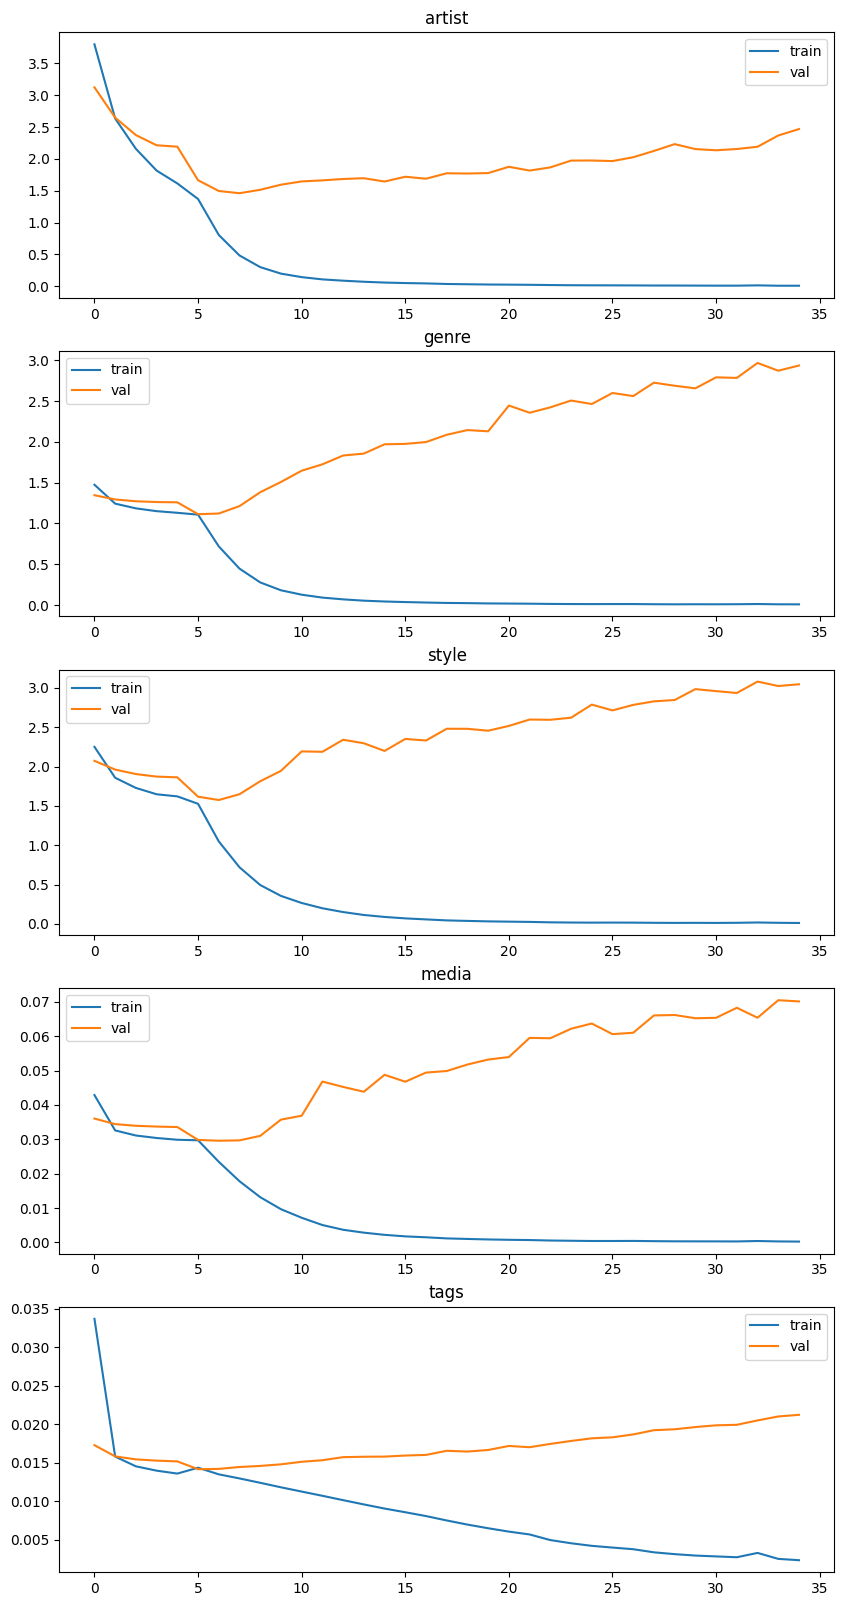

In [26]:
loss_viz()

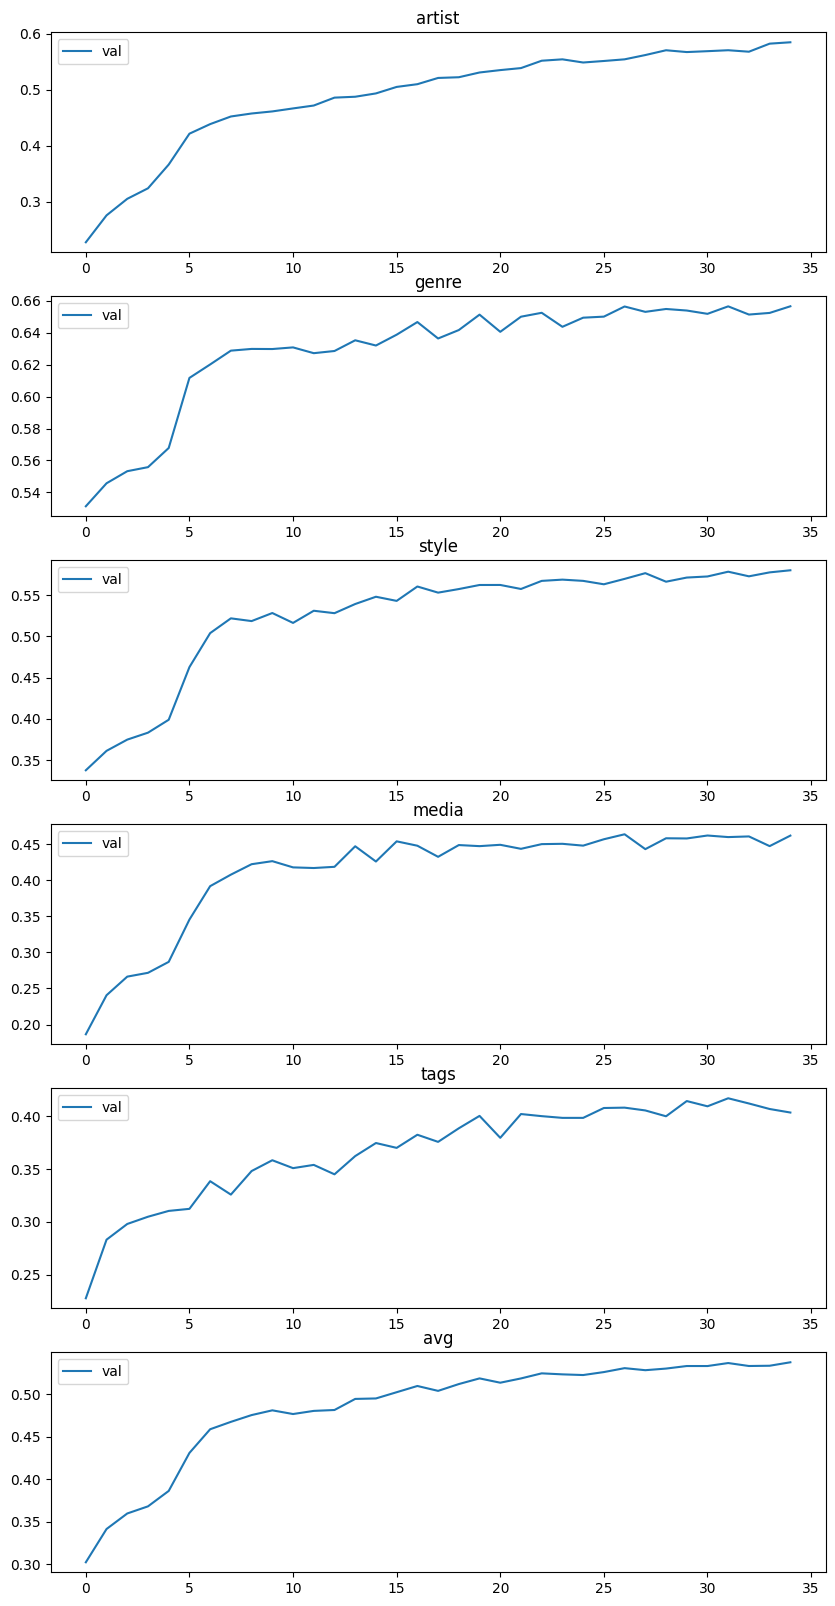

In [46]:
macro_f1_viz()

In [51]:
avg_macro_f1 = []
for csv_file in sorted(os.listdir(TRAIN_VIZ_DIR / "vavg_macro_f1")):
    avg_macro_f1 += list(pd.read_csv(TRAIN_VIZ_DIR / "vavg_macro_f1" / csv_file)["Value"].values)

print(f"The best result of validation avg macro f1 is at the {np.argmax(avg_macro_f1) + 1}th epoch.")
print(f"With a score of {np.max(avg_macro_f1)}.")

The best result of validation avg macro f1 is at the 35th epoch.
With a score of 0.5373549461364746.


In [78]:
# load the best model
from src.models.multiclassification.model import ViTForMultiClassification
from functools import partial
from src.models.multiclassification.data import get_multiclassification_dicts, compute_class_weight_tensors, transform_for_model

model = ViTForMultiClassification(*get_multiclassification_dicts())
model.to("cuda")

Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTModel: ['pooler.dense.weight', 'pooler.dense.bias']
- This IS expected if you are initializing ViTModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


ViTForMultiClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=7

In [80]:
model.load_state_dict(torch.load(MULTICLASSIFICATION_MODEL_DIR / "full" / "model-20230513_121917-35.pt")["model_state_dict"])
model.train(False)
from transformers import ViTImageProcessor
processor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")

In [81]:
dataset = load_from_disk(DATA_DIR / "processed" / "multiclassification_dataset")
class_weight_tensors = compute_class_weight_tensors(dataset, "cuda")
dataset = dataset.with_transform(partial(transform_for_model, processor=processor, device="cuda"))

In [82]:
test_dataloader = torch.utils.data.DataLoader(
    dataset["test"],
    batch_size=8,
)

In [83]:
results = evaluate(
    model,
    test_dataloader,
    class_weight_tensors,
    *[list(d.keys()) for d in get_multiclassification_dicts()],
    8,
    32//8
)

100%|██████████| 2212/2212 [08:53<00:00,  4.14it/s]


In [84]:
results

(92.65286856744216,
 [2.35425907741464,
  2.991217190909951,
  2.865208080331326,
  0.021898770528032057,
  0.06884663572904208],
 {'artist_accuracy': 0.6993105786618445,
  'artist_macro_precision': 0.6154203665051624,
  'artist_macro_recall': 0.5829196050233618,
  'artist_macro_f1': 0.5862963720648307,
  'style_accuracy': 0.5997965641952984,
  'style_macro_precision': 0.5841171050661121,
  'style_macro_recall': 0.5728221705935834,
  'style_macro_f1': 0.5740512721960334,
  'genre_accuracy': 0.7277915913200723,
  'genre_macro_precision': 0.678110908004751,
  'genre_macro_recall': 0.6468839532675804,
  'genre_macro_f1': 0.6594409792772451,
  'tags_hamming_loss': 0.005687743253142625,
  'tags_macro_precision': 0.5864382137369426,
  'tags_macro_recall': 0.3273901734170846,
  'tags_macro_f1': 0.3961297113144862,
  'media_hamming_loss': 0.024620611658709015,
  'media_macro_precision': 0.71293593738081,
  'media_macro_recall': 0.3719696826873494,
  'media_macro_f1': 0.46162278125964595,
  'av